<a href="https://colab.research.google.com/github/RokelisK123/gilusis/blob/main/BookNLP_StableDiffusion3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# <img src="https://www.gutenberg.org/gutenberg/pg-logo-129x80.png" width=50 height=50>   <font color='Orange'>Book NLP 5 - <br> <b>Text</b>  to <b>Image</b> with Stable Diffusion</font>





---





In [33]:
#@title Imports

from google.colab import files
import pandas as pd
#import urllib.request
import os.path
import re

from google.colab.data_table import DataTable
DataTable.max_columns = 50

import numpy as np
import cv2
import os
import requests
import json

# Add or modify styles in style_list
style_list = [
    # Cinematic & Modern Styles
    "Hyperrealistic cinematic 8K HDR, volumetric lighting, ray tracing",
    "Epic fantasy movie scene, Peter Jackson style, golden hour lighting",
    "Blade Runner 2049 cinematography, neon noir, atmospheric haze",
    "Studio Ghibli masterpiece, Hayao Miyazaki signature style",

    # Fine Art Styles
    "Oil painting by Ivan Aivazovsky, dramatic seascape style",
    "Gustav Klimt golden period, ornate Art Nouveau patterns",
    "Pre-Raphaelite masterpiece, John William Waterhouse style",
    "Renaissance painting by Caravaggio, dramatic chiaroscuro",

    # Digital & Contemporary
    "Unreal Engine 5 rendered scene, photorealistic textures",
    "Award-winning concept art, Artstation trending, dynamic composition",
    "Dark souls video game aesthetic, gothic fantasy",
    "Cyberpunk style, iridescent holographic, volumetric fog",

    # Traditional & Cultural
    "Traditional Chinese ink painting, misty mountains",
    "Medieval illuminated manuscript, gold leaf details",
    "Art Deco poster style, geometric patterns, metallic colors",
    "Ancient Greek pottery art style, red-figure technique",

    # Experimental & Mixed
    "Mixed media collage, watercolor and digital fusion",
    "Surrealist dreamscape, Salvador Dali meets HR Giger",
    "Ethereal fantasy scene, flowing fabrics, particle effects",
    "Steampunk baroque fusion, ornate mechanical details",

    # Photography Inspired
    "National Geographic photography, golden hour lighting",
    "Annie Leibovitz portrait style, dramatic studio lighting",
    "Vintage daguerreotype photograph, silver plate process",
    "Infrared photography style, ethereal glow"
]

# Additional style modifiers that can be appended
style_modifiers = [
    ", masterpiece",
    ", highly detailed",
    ", professional photography",
    ", dramatic lighting",
    ", volumetric lighting",
    ", cinematic composition",
    ", 8k resolution",
    ", photorealistic",
    ", trending on artstation",
    ", octane render"
]





---

#  <font color='Blue'> 1. Mount the drive</font>  



In [34]:
from google.colab import drive

import os
if os.path.isdir('/content/drive/MyDrive'):
    print('Google Drive is mounted.')
else:
    drive.mount('/content/drive')


Google Drive is mounted.



---

#  <font color='Blue'> 2. Get prompts</font>  

In [35]:
style = style_list[0]
negative_prompt='distorted, ugly, deformed, disfigured, poor details' # grayscale,


## There are several ways to write a prompt.

>The first is to simply modify the JSON snippet below.

>Another way is to simply take this Prompt [Example_for_prompt](https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/promt_for_scene_analysis.txt
), then add a TEXT part to it, then submit it to ChatGPT or Gemini and then replace the received response in place the JSON fragment below.

> The third way is to clean the JSON fragment and submit a .json file from the Internet instead.



In [36]:
prompt_response_json_text = """[
    {
        "scene_title": "Eglė Meets the Serpent Prince",
        "description": "Young Eglė finds a mysterious serpent in her clothes after bathing in the Baltic Sea with her sisters.",
        "scene_type": "EXT",
        "scene_date": "Ancient Lithuanian times",
        "location": "Baltic Sea shore",
        "time_of_day": "SUNSET",
        "dialog_summary": "The serpent prince Žilvinas asks for Eglė's hand in marriage, speaking in a gentle human voice.",
        "characters": [
            "Eglė",
            "Žilvinas the Serpent Prince",
            "Three sisters"
        ],
        "objects": [
            "traditional linen dress",
            "amber necklace",
            "woven basket",
            "green serpent",
            "sea shells",
            "Baltic waves",
            "pine trees"
        ],
        "object_part_of_object": [
            "scales;serpent",
            "crown;serpent prince",
            "embroidery;dress"
        ],
        "action_sequence": [
            "swimming",
            "emerging",
            "discovering",
            "trembling",
            "listening",
            "promising",
            "transforming"
        ],
        "text_phrases": [
            "waves gently lapping at the shore",
            "serpent coiled among the clothes",
            "golden sun setting over the Baltic",
            "mysterious voice from the serpent",
            "amber gleaming in the last rays of sun",
            "sisters watching in fear",
            "pine forest whispering ancient secrets"
        ]
    },
    {
        "scene_title": "The Underwater Palace",
        "description": "Eglė descends into the magical underwater kingdom of the serpents.",
        "scene_type": "INT",
        "scene_date": "Ancient Lithuanian times",
        "location": "Baltic Sea depths",
        "time_of_day": "TIMELESS",
        "dialog_summary": "Eglė enters her new home as the bride of the Serpent Prince, who reveals his true form as a handsome young man.",
        "characters": [
            "Eglė",
            "Žilvinas in human form",
            "Serpent attendants"
        ],
        "objects": [
            "amber walls",
            "pearl throne",
            "coral gardens",
            "crystal windows",
            "golden fish",
            "magical mirrors",
            "seaweed tapestries"
        ],
        "object_part_of_object": [
            "pillars;palace",
            "doors;amber",
            "decorations;coral"
        ],
        "action_sequence": [
            "descending",
            "marveling",
            "transforming",
            "meeting",
            "dancing",
            "exploring",
            "embracing"
        ],
        "text_phrases": [
            "palace glowing with amber light",
            "schools of golden fish swimming by",
            "coral gardens swaying in currents",
            "Žilvinas revealing his human form",
            "magical lights dancing in water",
            "pearl-encrusted throne room",
            "seaweed forests surrounding the palace"
        ]
    }
]
"""

In [37]:
#@title If the prompt_response_json_text variable is an empty string then the json file from the Internet must be submitted

# Check if we need to fetch JSON from URL or use existing text
if not prompt_response_json_text:
    # List of available book codes
    BOOK_CODES = ['84', '244', '2701', '2852', '42671']
    selected_book = '2852'  # Currently using Hound of the Baskervilles

    # Construct URL and fetch JSON data
    base_url = "https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/gpt4_scene_info_"
    url = f"{base_url}{selected_book}.json"

    # Get JSON response
    response = requests.get(url)
    prompt_response_json_text = response.text
else:
    # Wrap existing JSON text in proper structure
    prompt_response_json_text = f'{{"1":{prompt_response_json_text}}}'

In [38]:
data = json.loads(prompt_response_json_text)
print("JSON data:", data)


JSON data: {'1': [{'scene_title': 'Eglė Meets the Serpent Prince', 'description': 'Young Eglė finds a mysterious serpent in her clothes after bathing in the Baltic Sea with her sisters.', 'scene_type': 'EXT', 'scene_date': 'Ancient Lithuanian times', 'location': 'Baltic Sea shore', 'time_of_day': 'SUNSET', 'dialog_summary': "The serpent prince Žilvinas asks for Eglė's hand in marriage, speaking in a gentle human voice.", 'characters': ['Eglė', 'Žilvinas the Serpent Prince', 'Three sisters'], 'objects': ['traditional linen dress', 'amber necklace', 'woven basket', 'green serpent', 'sea shells', 'Baltic waves', 'pine trees'], 'object_part_of_object': ['scales;serpent', 'crown;serpent prince', 'embroidery;dress'], 'action_sequence': ['swimming', 'emerging', 'discovering', 'trembling', 'listening', 'promising', 'transforming'], 'text_phrases': ['waves gently lapping at the shore', 'serpent coiled among the clothes', 'golden sun setting over the Baltic', 'mysterious voice from the serpent',

In [39]:
number_of_prompts = 10 #+1000

scene_nr = 1
prompts = []
scene_dates = []
scene_locations = []
scene_objects = []
for key, value in data.items():
  for item in value:
    print(f"{scene_nr:>5} {item.get('description')}")
    prompts.append(item.get('description'))
    scene_dates.append(item.get('scene_date'))
    scene_locations.append(item.get('location'))
    scene_objects.append(item.get('objects'))
    scene_nr += 1

  if scene_nr > number_of_prompts:
    break

    1 Young Eglė finds a mysterious serpent in her clothes after bathing in the Baltic Sea with her sisters.
    2 Eglė descends into the magical underwater kingdom of the serpents.


---

#  <font color='Blue'>🔗 Diffusers</font>  

In [40]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy peft

In [41]:
%%capture
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline, TCDScheduler
from huggingface_hub import hf_hub_download

# Choose either 8 or 12 steps:
num_inference_steps = 12

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-CFG-lora.safetensors"
device = "cuda"

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16").to(device)
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

0    Ancient Lithuanian times. Location is Baltic Sea shore. Objects: traditional linen dress, amber necklace, woven basket, green serpent, sea shells, Baltic waves, pine trees. Hyperrealistic cinematic 8K HDR, volumetric lighting, ray tracing. Young Eglė finds a mysterious serpent in her clothes after bathing in the Baltic Sea with her sisters. 


  0%|          | 0/12 [00:00<?, ?it/s]

1    Ancient Lithuanian times. Location is Baltic Sea depths. Objects: amber walls, pearl throne, coral gardens, crystal windows, golden fish, magical mirrors, seaweed tapestries. Hyperrealistic cinematic 8K HDR, volumetric lighting, ray tracing. Eglė descends into the magical underwater kingdom of the serpents. 


  0%|          | 0/12 [00:00<?, ?it/s]

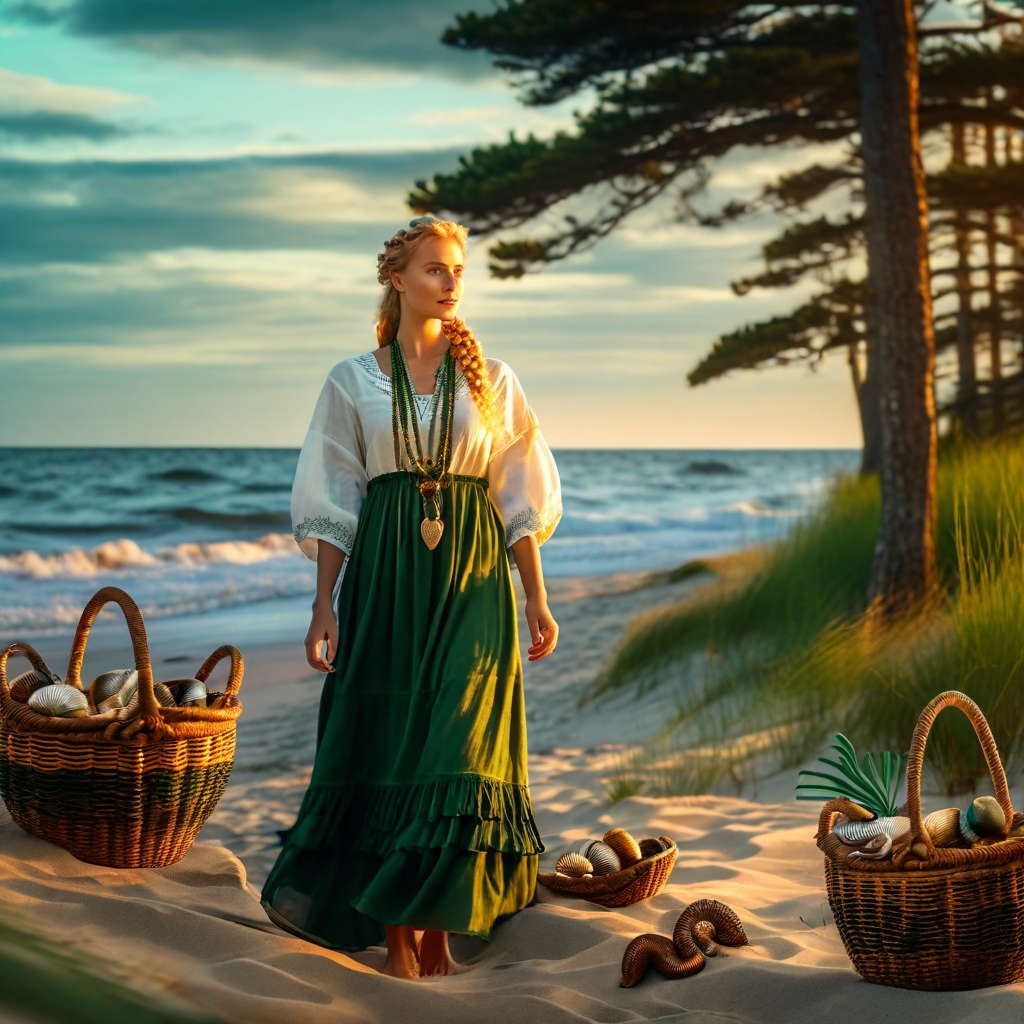

In [42]:
seed = random.randint(0, sys.maxsize)
guidance_scale = 7.0 ## Pick a value between 5.0 and 8.0:
eta = 0.3 # # Decrease eta (min: 0, max: 1.0) to get more details with multi-step inference:


all_images_list = []
for image_nr, prompt in enumerate(prompts):
        #images = model.text_to_image(style  + ' ' +prompt, batch_size=1)

        if 'scene_dates' in globals():
          prompt = scene_dates[image_nr]  + ". Location is "+scene_locations[image_nr]+". Objects: " + (", ".join(scene_objects[image_nr]))+ ". " + style + ". "  + prompt
        print(f'{image_nr}    {prompt} ')
        images = pipe( prompt = prompt,  num_inference_steps = num_inference_steps ,  guidance_scale = guidance_scale,   eta = eta,    generator = torch.Generator(device).manual_seed(seed),  negative_prompt=negative_prompt   ).images
        image_info_tuple = (image_nr, prompt, images[0]  )
        all_images_list.append(image_info_tuple)
        #break

all_images_list[0][2]

In [43]:

image_list = [np.array(img[2]) for img in all_images_list]

In [44]:


def save_images(image_list, directory):

    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, image in enumerate(image_list):
        filename = f"image_{i}.jpg"  # Adjust the filename format as needed
        filepath = os.path.join(directory, filename)
        cv2.imwrite(filepath, image)


directory = "saved_images"

save_images(image_list, directory)

!zip -r saved_images.zip saved_images
!cp saved_images.zip /content/drive/MyDrive/saved_images.zip

updating: saved_images/ (stored 0%)
updating: saved_images/image_0.jpg (deflated 0%)
  adding: saved_images/image_1.jpg (deflated 0%)



---

#  <font color='Blue'>🎬 Let's try to put all the images into a video file with audio track </font>  

In [45]:
!pip install gTTS -q

In [46]:
'''
# Import the required module for text
# to speech conversion
from gtts import gTTS

# This module is imported so that we can
# play the converted audio
import os

# The text that you want to convert to audio
mytext = 'Welcome to geeksforgeeks Joe!'

# Language in which you want to convert
language = 'en'

# Passing the text and language to the engine,
# here we have marked slow=False. Which tells
# the module that the converted audio should
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)

# Saving the converted audio in a mp3 file named
# welcome
myobj.save("welcome.mp3")
'''

'\n# Import the required module for text\n# to speech conversion\nfrom gtts import gTTS\n\n# This module is imported so that we can\n# play the converted audio\nimport os\n\n# The text that you want to convert to audio\nmytext = \'Welcome to geeksforgeeks Joe!\'\n\n# Language in which you want to convert\nlanguage = \'en\'\n\n# Passing the text and language to the engine,\n# here we have marked slow=False. Which tells\n# the module that the converted audio should\n# have a high speed\nmyobj = gTTS(text=mytext, lang=language, slow=False)\n\n# Saving the converted audio in a mp3 file named\n# welcome\nmyobj.save("welcome.mp3")\n'

In [47]:
from gtts import gTTS

mp3_list = []
for image_nr, prompt in enumerate(prompts):
  mytext = prompt
  myobj = gTTS(text=mytext, lang='en', slow=False, tld='co.uk')  # https://gtts.readthedocs.io/en/latest/module.html#gtts.tts.gTTS
  myobj.save("welcome"+str(image_nr)+".mp3")
  mp3_list.append("welcome"+str(image_nr)+".mp3")
  print(f'{image_nr} ', end='')



0 1 

In [48]:
!pip install -q moviepy pillow

In [49]:
import numpy as np
from PIL import Image
from moviepy.editor import ImageSequenceClip, AudioFileClip, concatenate_videoclips

frames = [np.array(img) for img in image_list] # images to numpy arrays

video_clips = []
for i, frame in enumerate(frames):
    audio_clip = AudioFileClip(mp3_list[i])

    ##img_clip = ImageSequenceClip([frame], fps=1)  # 1 frame per second
    img_clip = ImageSequenceClip([frame], durations=[audio_clip.duration])  # 1 frame per second

    #img_clip = img_clip.set_duration(audio_clip.duration)  # Set the duration of the image clip to match the audio clip

    img_clip = img_clip.set_audio(audio_clip)

    video_clips.append(img_clip)

final_clip = concatenate_videoclips(video_clips)

final_clip.write_videofile("output_video_with_audio.mp4", codec="libx264",fps=1)
!cp output_video_with_audio.mp4 /content/drive/MyDrive/

Moviepy - Building video output_video_with_audio.mp4.
MoviePy - Writing audio in output_video_with_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_video_with_audio.mp4



Moviepy - Done !
Moviepy - video ready output_video_with_audio.mp4


#


---

#  <font color='Blue'>⛔ 3. Old Code Delete all </font>  

In [50]:
#!pip install tensorflow keras_cv --upgrade --quiet

In [51]:
'''
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
'''


'\nimport time\nimport keras_cv\nfrom tensorflow import keras\nimport matplotlib.pyplot as plt\nimport numpy as np\n'

In [52]:

#model = keras_cv.models.StableDiffusion(    img_width=512, img_height=512, jit_compile=False )



In [53]:
'''

images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

'''

'\n\nimages = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)\n\n\ndef plot_images(images):\n    plt.figure(figsize=(20, 20))\n    for i in range(len(images)):\n        ax = plt.subplot(1, len(images), i + 1)\n        plt.imshow(images[i])\n        plt.axis("off")\n\n\nplot_images(images)\n\n'

In [54]:
'''

promt_text = "The detective watches from the top of the mountain. A flaming dog runs along the mountain"

images = []

for i, style in enumerate(style_list[:]):
    promt_text_final = promt_text + ", style of " + style   + ", high quality, highly detailed"
    print(f"{str(i):<3} {promt_text_final}")
    images_tmp = model.text_to_image(promt_text_final, batch_size=1)
    images.append(images_tmp[0])

'''



'\n\npromt_text = "The detective watches from the top of the mountain. A flaming dog runs along the mountain"\n\nimages = []\n\nfor i, style in enumerate(style_list[:]):\n    promt_text_final = promt_text + ", style of " + style   + ", high quality, highly detailed"\n    print(f"{str(i):<3} {promt_text_final}")\n    images_tmp = model.text_to_image(promt_text_final, batch_size=1)\n    images.append(images_tmp[0])\n\n'

In [55]:
'''
n_rows = len(images) // 3 + (len(images) % 3 > 0)
n_cols = min(len(images), 3)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 100))


print(f"promt_text = {promt_text}")

axs = axs.flatten() # Flatten the subplots array to make it easier to iterate over
for i, img in enumerate(images):
    axs[i].imshow(img, aspect='auto')
    axs[i].axis('off')
    axs[i].set_title(f"{style_list[i]}", fontsize=12)

plt.show()
'''

'\nn_rows = len(images) // 3 + (len(images) % 3 > 0)\nn_cols = min(len(images), 3)\n\nfig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 100))\n\n\nprint(f"promt_text = {promt_text}")\n\naxs = axs.flatten() # Flatten the subplots array to make it easier to iterate over\nfor i, img in enumerate(images):\n    axs[i].imshow(img, aspect=\'auto\')\n    axs[i].axis(\'off\')\n    axs[i].set_title(f"{style_list[i]}", fontsize=12)\n\nplt.show()\n'


---

#  <font color='Blue'>⛔4. Let's try to illustrate our book </font>  

In [56]:
#@title We load the word and paragraph tables of the book
'''
wn_df_book_token_spacy = pd.read_csv('/content/drive/MyDrive/wn_df_book_token_spacy.tsv', sep='\t')
df_paragraphs = pd.read_csv('/content/drive/MyDrive/df_paragraphs.tsv', sep='\t')
df_chapters_info = pd.read_csv('/content/drive/MyDrive/df_chapters_info.tsv', sep='\t')

'''

"\nwn_df_book_token_spacy = pd.read_csv('/content/drive/MyDrive/wn_df_book_token_spacy.tsv', sep='\t')\ndf_paragraphs = pd.read_csv('/content/drive/MyDrive/df_paragraphs.tsv', sep='\t')\ndf_chapters_info = pd.read_csv('/content/drive/MyDrive/df_chapters_info.tsv', sep='\t')\n\n"

In [57]:
#@title We collect words that represent a physical object into phrases that will be fed to the Stable Diffusion model
'''
prompts_dic = {}
number_of_prompts = 0

for index_ch, row_ch in df_chapters_info.iterrows():
    chapter = row_ch['chapter']
    chapter_name = row_ch['chapter_name']

    row_nr = -1
    prev_token_in_chunk = -1
    phrase = ''

    noun_chunk_has_artifact = False
    noun_chunk_has_PERSON = False

    prompt = ''
    prompts = []

    df_one_chapter = wn_df_book_token_spacy[(wn_df_book_token_spacy['chapter'] == chapter)  & (wn_df_book_token_spacy['is_quote'] == 0)]
    for index, row in df_one_chapter.iterrows():
        token = row['token']
        token_in_chunk = row['token_in_chunk']
        wn_lesk_lexname = row['wn_lesk_lexname']
        ent_type = row['ent_type']

        if wn_lesk_lexname == 'noun.artifact':
          noun_chunk_has_artifact = True
        if ent_type == 'PERSON':
          noun_chunk_has_PERSON = True


        if token_in_chunk == 1 :
            phrase += ' ' + token
            chunk_end_index = index
            if token_in_chunk != prev_token_in_chunk :
                chunk_start_index = index


        if token_in_chunk == 0:
            if prev_token_in_chunk == 1 :
              chunk_start_index = index
              if noun_chunk_has_PERSON or noun_chunk_has_artifact:
                if phrase not in prompt:
                  prompt += ' ; ' + phrase
            phrase = ''
            noun_chunk_has_artifact = False
            noun_chunk_has_PERSON = False


        if len(prompt)>100:
          prompts.append(prompt)
          print(f"chapter: {chapter:<2} prompt nr.: {len(prompts):<3}  ->  {prompt.strip()} ")
          #print(f"{prompt.strip()} ")
          prompt = ''

        prev_token_in_chunk = token_in_chunk


    prompts_dic[chapter] = prompts
    print(f"Chapter: {chapter:<2}  Number of prompts: {len(prompts):<2} \n\n ")
    number_of_prompts += len(prompts)

print(f"Number of prompts in the book:  {number_of_prompts}  ")
'''


'\nprompts_dic = {}\nnumber_of_prompts = 0\n\nfor index_ch, row_ch in df_chapters_info.iterrows():\n    chapter = row_ch[\'chapter\']\n    chapter_name = row_ch[\'chapter_name\']\n\n    row_nr = -1\n    prev_token_in_chunk = -1\n    phrase = \'\'\n\n    noun_chunk_has_artifact = False\n    noun_chunk_has_PERSON = False\n\n    prompt = \'\'\n    prompts = []\n\n    df_one_chapter = wn_df_book_token_spacy[(wn_df_book_token_spacy[\'chapter\'] == chapter)  & (wn_df_book_token_spacy[\'is_quote\'] == 0)]\n    for index, row in df_one_chapter.iterrows():\n        token = row[\'token\']\n        token_in_chunk = row[\'token_in_chunk\']\n        wn_lesk_lexname = row[\'wn_lesk_lexname\']\n        ent_type = row[\'ent_type\']\n\n        if wn_lesk_lexname == \'noun.artifact\':\n          noun_chunk_has_artifact = True\n        if ent_type == \'PERSON\':\n          noun_chunk_has_PERSON = True\n\n\n        if token_in_chunk == 1 :\n            phrase += \' \' + token\n            chunk_end_index 

In [58]:
'''
style =  " style of steampunk digital art ; "  # , high quality, highly detailed,
image_nr = 1
all_images_list = []
end_ganeration = False
for chapter in prompts_dic:
    prompts = prompts_dic[chapter]
    for prompt in prompts:
        print(f'{image_nr} {chapter}   {prompt} ')
        images = model.text_to_image(style  + ' ' +prompt, batch_size=1)
        image_info_tuple = (chapter, prompt, images[0]  )
        all_images_list.append(image_info_tuple)
        image_nr += 1

        if image_nr > 150:
          end_ganeration = True
          break

    if end_ganeration:
      break
'''



'\nstyle =  " style of steampunk digital art ; "  # , high quality, highly detailed,\nimage_nr = 1\nall_images_list = []\nend_ganeration = False\nfor chapter in prompts_dic:\n    prompts = prompts_dic[chapter]\n    for prompt in prompts:\n        print(f\'{image_nr} {chapter}   {prompt} \')\n        images = model.text_to_image(style  + \' \' +prompt, batch_size=1)\n        image_info_tuple = (chapter, prompt, images[0]  )\n        all_images_list.append(image_info_tuple)\n        image_nr += 1\n\n        if image_nr > 150:\n          end_ganeration = True\n          break\n\n    if end_ganeration:\n      break\n'

In [59]:
'''
import matplotlib.pyplot as plt
print(all_images_list[3][1])
plt.axis("off")
plt.imshow(all_images_list[3][2])
'''

'\nimport matplotlib.pyplot as plt\nprint(all_images_list[3][1])\nplt.axis("off")\nplt.imshow(all_images_list[3][2])\n'


---

#  <font color='Blue'>⛔ 5. Let's try to put all the images into a video file </font>  

In [60]:
'''
import cv2
import numpy as np

video_name = 'output_video3.mp4'  #

image_shape = (512, 512)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video = cv2.VideoWriter(video_name, fourcc, 1, image_shape)


font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
font_color = (255, 255, 255)
font_thickness = 1


for image_tuple in all_images_list:
    text = image_tuple[1]
    print(text)
    image = image_tuple[2]

    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_with_text = image.copy()

    cv2.putText(image, text, (2, 20), font, font_scale, font_color, font_thickness)

    video.write(image)

cv2.destroyAllWindows()
video.release()
'''

"\nimport cv2\nimport numpy as np\n\nvideo_name = 'output_video3.mp4'  #\n\nimage_shape = (512, 512)\n\nfourcc = cv2.VideoWriter_fourcc(*'mp4v')\n\nvideo = cv2.VideoWriter(video_name, fourcc, 1, image_shape)\n\n\nfont = cv2.FONT_HERSHEY_SIMPLEX\nfont_scale = 0.3\nfont_color = (255, 255, 255)\nfont_thickness = 1\n\n\nfor image_tuple in all_images_list:\n    text = image_tuple[1]\n    print(text)\n    image = image_tuple[2]\n\n    image = np.array(image)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n\n    image_with_text = image.copy()\n\n    cv2.putText(image, text, (2, 20), font, font_scale, font_color, font_thickness)\n\n    video.write(image)\n\ncv2.destroyAllWindows()\nvideo.release()\n"

In [61]:

#image_list = [np.array(img[2]) for img in all_images_list]

In [62]:
'''
import numpy as np
from PIL import Image
from moviepy.editor import ImageSequenceClip



# Convert images to numpy arrays
frames = [np.array(img) for img in image_list]

# Create the video clip
fps = 1
clip = ImageSequenceClip(frames, fps=fps)

# Write the video file
clip.write_videofile("output_video.mp4", codec="libx264")
'''

'\nimport numpy as np\nfrom PIL import Image\nfrom moviepy.editor import ImageSequenceClip\n\n\n\n# Convert images to numpy arrays\nframes = [np.array(img) for img in image_list]\n\n# Create the video clip\nfps = 1\nclip = ImageSequenceClip(frames, fps=fps)\n\n# Write the video file\nclip.write_videofile("output_video.mp4", codec="libx264")\n'